In [1]:
# In notebook cell:
!pip install --upgrade pip
!pip install scanpy==1.9.3 transformers==4.29.2 torch==1.9.1 scikit-learn networkx tqdm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.2 MB/s eta 0:00:0000:0100:010m
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os

In [4]:
# 0. Configuration - edit these paths & params
# ---------------------------
h5ad_path = "Immune_ALL_human (1).h5ad"   # <-- change to your .h5ad
output_base = "/users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500"
os_model_dir = "biobert_v1.1_pubmed_pytorch_model"  # optional if you use HF model
bio_name_txt = os.path.join(output_base, "bio_name.txt")
embeddings_npy = os.path.join(output_base, "biovect768.npy")
edge_list_csv = os.path.join(output_base, "grn_edge_list.csv")
graph_gml = os.path.join(output_base, "grn_graph.gml")

# Parameters
batch_size = 128          # number of names to embed per batch (adjust by RAM/compute)
n_neighbors = 50          # how many neighbors per gene to keep in GRN (controls sparsity)
use_cuda = False          # set True if you have a working GPU + compatible torch


In [5]:
# 1. Imports
# ---------------------------
import os
os.makedirs(output_base, exist_ok=True)

import scanpy as sc
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import pandas as pd

/users/hmcmakhubela/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 2. Load .h5ad and extract unique gene names
# ---------------------------
print("Loading .h5ad:", h5ad_path)
adata = sc.read_h5ad('Immune_ALL_human (1).h5ad')
# adata.var_names are assumed to be gene symbols / features
genes = list(adata.var_names)
# ensure unique and deterministic order
genes = list(dict.fromkeys(genes))
print(f"Found {len(genes)} genes.")

# Save bio_name.txt (one per line) for scGREAT compatibility
with open(bio_name_txt, "w") as fh:
    for g in genes:
        fh.write(f"{g}\n")
print("Saved gene list to:", bio_name_txt)

Loading .h5ad: Immune_ALL_human (1).h5ad
Found 12303 genes.
Saved gene list to: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/bio_name.txt


In [8]:
# 3. Load BioBERT via transformers (HuggingFace) - CPU/GPU aware
# ---------------------------
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# Use the dmis-lab BioBERT model (AutoModel). This will download to HF cache on first run.
model_name = "dmis-lab/biobert-base-cased-v1.1"
print("Loading tokenizer & model:", model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# helper to embed a batch of texts (returns numpy array)
def embed_texts(text_list):
    # Use tokenizer batching with truncation/padding; returns tensors on device
    enc = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    for k in list(enc.keys()):
        enc[k] = enc[k].to(device)
    with torch.no_grad():
        out = model(**enc)
        # mean pooling over sequence length tokens
        # out.last_hidden_state shape: (batch_size, seq_len, hidden_dim)
        emb = out.last_hidden_state.mean(dim=1)  # (batch_size, hidden_dim)
        emb = emb.detach().cpu().numpy()
    return emb
    

Using device: cpu
Loading tokenizer & model: dmis-lab/biobert-base-cased-v1.1


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# 4. Generate embeddings in batches and save .npy
# ---------------------------
print("Generating embeddings in batches (batch_size=%d)..." % batch_size)
all_embs = []
for i in tqdm(range(0, len(genes), batch_size)):
    batch = genes[i:i+batch_size]
    emb = embed_texts(batch)
    all_embs.append(emb)
all_embs = np.vstack(all_embs)
print("Embeddings shape:", all_embs.shape)   # expected (n_genes, 768)

# Save embeddings
np.save(embeddings_npy, all_embs)
print("Saved embeddings to:", embeddings_npy)

Generating embeddings in batches (batch_size=128)...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 97/97 [00:24<00:00,  3.91it/s]

Embeddings shape: (12303, 768)
Saved embeddings to: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/biovect768.npy


In [10]:
# 5. Build sparse GRN using NearestNeighbors (cosine)
#    For each gene, keep top-n_neighbors nearest genes by cosine distance -> edge weights = 1 - cosine_distance
# ---------------------------
print("Computing k-nearest neighbors (n_neighbors=%d)..." % n_neighbors)
# sklearn's NearestNeighbors with metric='cosine' returns distances in [0,2] (cosine distance = 1 - cosine similarity)
nn = NearestNeighbors(n_neighbors=n_neighbors+1, metric="cosine", n_jobs=-1)  # +1 because nearest includes itself
nn.fit(all_embs)
distances, indices = nn.kneighbors(all_embs, return_distance=True)

# Build edges: for each i, neighbors indices[i][1:] (skip self at position 0)
edges = []
for i, neighs in enumerate(indices):
    i_gene = genes[i]
    for j_idx, j in enumerate(neighs[1:]):  # skip first (self)
        j_gene = genes[j]
        dist = distances[i][j_idx+1]
        weight = 1.0 - dist  # approximate cosine similarity
        # optional: ignore tiny weights (near 0) - but we keep all for now
        edges.append((i_gene, j_gene, float(weight)))

# Save edge list (directed) as CSV
edges_df = pd.DataFrame(edges, columns=["source","target","weight"])
edges_df.to_csv(edge_list_csv, index=False)
print("Saved edge list (directed) to:", edge_list_csv)

Computing k-nearest neighbors (n_neighbors=50)...
Saved edge list (directed) to: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/grn_edge_list.csv


In [11]:
# 6. Build an undirected graph (optional) and save GML for visualization
# ---------------------------
G = nx.Graph()
# Add weighted edges by taking max(weight, existing) to combine directed edges
for u, v, w in edges:
    if G.has_edge(u, v):
        # keep the max weight for symmetric edges
        if G[u][v]["weight"] < w:
            G[u][v]["weight"] = w
    else:
        G.add_edge(u, v, weight=w)
print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

nx.write_gml(G, graph_gml)
print("Saved graph (GML) to:", graph_gml)

Graph nodes: 12303 edges: 474834
Saved graph (GML) to: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/grn_graph.gml


In [12]:
# 7. Quick sanity-check: top hubs and sample neighbors
# ---------------------------
# top-degree nodes
deg_sorted = sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes (degree weight):")
for node,score in deg_sorted[:10]:
    print(node, round(score,3))

# show neighbors of a sample gene
sample_gene = genes[0]
print("\nNeighbors for sample gene:", sample_gene)
for nbr,attrs in G[sample_gene].items():
    print(nbr, round(attrs["weight"],3))

print("\nPipeline complete. You now have embeddings, a sparse GRN (edge list + GML), and a network object.")

Top 10 hub genes (degree weight):
NRBP2 663.482
AMD1 611.119
MZB1 481.292
NRBP1 459.925
MDN1 456.797
NCS1 428.344
SRBD1 427.575
MXI1 414.272
SMPD2 408.067
MBD1 402.912

Neighbors for sample gene: LINC00115
LINC00470 0.99
LINC00346 0.989
LINC00327 0.989
LINC00240 0.988
LINC00336 0.988
LINC00167 0.988
LINC00299 0.988
LINC00482 0.987
LINC00265 0.987
LINC00426 0.987
LINC00309 0.987
LINC00526 0.986
LINC00324 0.985
LINC00304 0.984
LINC00102 0.978
LINC00494 0.977
LINC00511 0.975
LINC00092 0.974
CCDC146 0.91
CCDC136 0.908
CCDC126 0.904
CCDC137 0.899
CCDC127 0.899
CCDC106 0.897
CCDC116 0.897
CCDC134 0.897
CCDC124 0.897
CCDC125 0.896
CCDC138 0.894
CCDC154 0.894
CCDC122 0.893
ZFAND6 0.891
CCDC149 0.891
CCDC157 0.89
CCDC117 0.89
CCDC66 0.89
CCDC142 0.89
CCDC115 0.889
ZFAND5 0.889
CCDC114 0.889
CCDC120 0.888
CCDC107 0.887
CCDC113 0.886
CCDC96 0.886
CCDC155 0.885
CCDC57 0.882
CCDC153 0.881
CCDC77 0.881
CCDC152 0.881
CCDC69 0.88

Pipeline complete. You now have embeddings, a sparse GRN (edge list + G

In [13]:
# 8. Optional: Restrict to TF → target network (if you have TF list)
# ============================================================

# --- CONFIG ---
tf_list_path = "/path/to/TF_list.txt"   # e.g., a text file with one TF symbol per line
tf_edges_csv = os.path.join(output_base, "TF_target_edges.csv")
tf_graph_gml = os.path.join(output_base, "TF_target_graph.gml")

# --- LOAD TF LIST ---
if os.path.exists(tf_list_path):
    with open(tf_list_path, "r") as f:
        tf_list = [line.strip() for line in f if line.strip()]
    tf_list = list(set(tf_list))
    print(f"Loaded {len(tf_list)} transcription factors.")
else:
    print("⚠️ TF list file not found; skipping TF filtering.")
    tf_list = []

# --- FILTER EDGES ---
if tf_list:
    tf_edges_df = edges_df[edges_df["source"].isin(tf_list)]
    print(f"Filtered TF → target edges: {len(tf_edges_df)} of {len(edges_df)} total.")
    
    # Save to CSV
    tf_edges_df.to_csv(tf_edges_csv, index=False)
    print("Saved TF→target edge list to:", tf_edges_csv)
    
    # Build TF→target graph
    TF_G = nx.from_pandas_edgelist(tf_edges_df, "source", "target", edge_attr="weight", create_using=nx.DiGraph())
    nx.write_gml(TF_G, tf_graph_gml)
    print("Saved TF→target GML graph to:", tf_graph_gml)
else:
    print("Skipping TF→target network construction.")

⚠️ TF list file not found; skipping TF filtering.
Skipping TF→target network construction.


In [21]:
# ============================================================
# 9. Combine embedding similarity with expression correlation (fixed)
# ============================================================

from scipy.stats import spearmanr
from tqdm import tqdm

print("Computing expression correlation matrix (Spearman)...")
expr_matrix = adata.X
if not isinstance(expr_matrix, np.ndarray):
    expr_matrix = expr_matrix.toarray()

# Limit for memory safety
top_genes = 1000
sub_genes = genes[:top_genes]
X_sub = expr_matrix[:, :top_genes]
emb_sub = all_embs[:top_genes]  
print(f"Computing correlations for top {top_genes} genes...")

# --- Option 1: Direct full Spearman (faster) ---
try:
    corr_mat, _ = spearmanr(X_sub, axis=0)
    corr_mat = np.nan_to_num(corr_mat, nan=0.0)
    # Only keep gene–gene part (Spearman returns cell+gene combined sometimes)
    corr_mat = corr_mat[-top_genes:, -top_genes:]
    print("Correlation matrix computed using vectorized method.")
except Exception as e:
    print("⚠️ Full Spearman failed, falling back to slow loop mode:", e)
    
    # --- Option 2: Loop version (memory safe) ---
    n_genes = X_sub.shape[1]
    corr_mat = np.zeros((n_genes, n_genes))
    for i in tqdm(range(n_genes)):
        rho_vec = []
        for j in range(n_genes):
            rho, _ = spearmanr(X_sub[:, i], X_sub[:, j])
            rho_vec.append(rho)
        corr_mat[i, :] = rho_vec

corr_mat = np.nan_to_num(corr_mat, nan=0.0)
print("Correlation matrix shape:", corr_mat.shape)

# --- Build combined consensus edges ---
from sklearn.neighbors import NearestNeighbors

n_neighbors = 50   # same as before
nn_corr = NearestNeighbors(n_neighbors=n_neighbors+1, metric="cosine", n_jobs=-1)
nn_corr.fit(emb_sub)
distances, indices = nn_corr.kneighbors(emb_sub)

alpha = 0.6  # weight for BioBERT similarity
edges_combined = []

for i, neighs in enumerate(indices):
    for j_idx, j in enumerate(neighs[1:]):  # skip self
        sim_emb = 1 - distances[i][j_idx+1]   # cosine similarity
        sim_corr = corr_mat[i, j]
        combined_weight = alpha*sim_emb + (1-alpha)*max(sim_corr, 0)
        edges_combined.append((sub_genes[i], sub_genes[j], combined_weight))

# --- Create and save consensus DataFrame ---
consensus_df = pd.DataFrame(edges_combined, columns=["source", "target", "weight"])
consensus_csv = os.path.join(output_base, "consensus_grn.csv")
consensus_df.to_csv(consensus_csv, index=False)
print("✅ Consensus GRN created and saved:", consensus_csv)


Computing expression correlation matrix (Spearman)...
Computing correlations for top 1000 genes...
Correlation matrix computed using vectorized method.
Correlation matrix shape: (1000, 1000)
✅ Consensus GRN created and saved: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/consensus_grn.csv


In [22]:
# 10. Filter top edges by percentile and prepare Cytoscape export
# ============================================================

top_percent = 5  # keep top 5% strongest edges
threshold = np.percentile(consensus_df['weight'], 100 - top_percent)
filtered_df = consensus_df[consensus_df['weight'] >= threshold].copy()
print(f"Filtered top {top_percent}% edges: {len(filtered_df)} of {len(consensus_df)} total.")

# Save filtered consensus GRN
filtered_csv = os.path.join(output_base, "consensus_grn_top5pct.csv")
filtered_df.to_csv(filtered_csv, index=False)
print("Saved filtered consensus GRN to:", filtered_csv)

Filtered top 5% edges: 2500 of 50000 total.
Saved filtered consensus GRN to: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/consensus_grn_top5pct.csv


In [23]:
# 11. Prepare Cytoscape-ready node and edge tables
# ============================================================

# Node table: all genes in filtered edges
nodes = pd.DataFrame({'id': pd.unique(filtered_df[['source', 'target']].values.ravel())})
nodes['type'] = 'gene'
# Add TF annotation if TF list available
if tf_list:
    nodes['type'] = nodes['id'].apply(lambda x: 'TF' if x in tf_list else 'gene')

# Edge table already has source/target/weight
edges_cyto = filtered_df.copy()
edges_cyto.rename(columns={'weight': 'interaction_score'}, inplace=True)

# Save node and edge tables for Cytoscape
nodes_csv = os.path.join(output_base, "cytoscape_nodes.csv")
edges_csv = os.path.join(output_base, "cytoscape_edges.csv")
nodes.to_csv(nodes_csv, index=False)
edges_cyto.to_csv(edges_csv, index=False)
print("Saved Cytoscape node/edge tables:", nodes_csv, edges_csv)

Saved Cytoscape node/edge tables: /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/cytoscape_nodes.csv /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/cytoscape_edges.csv


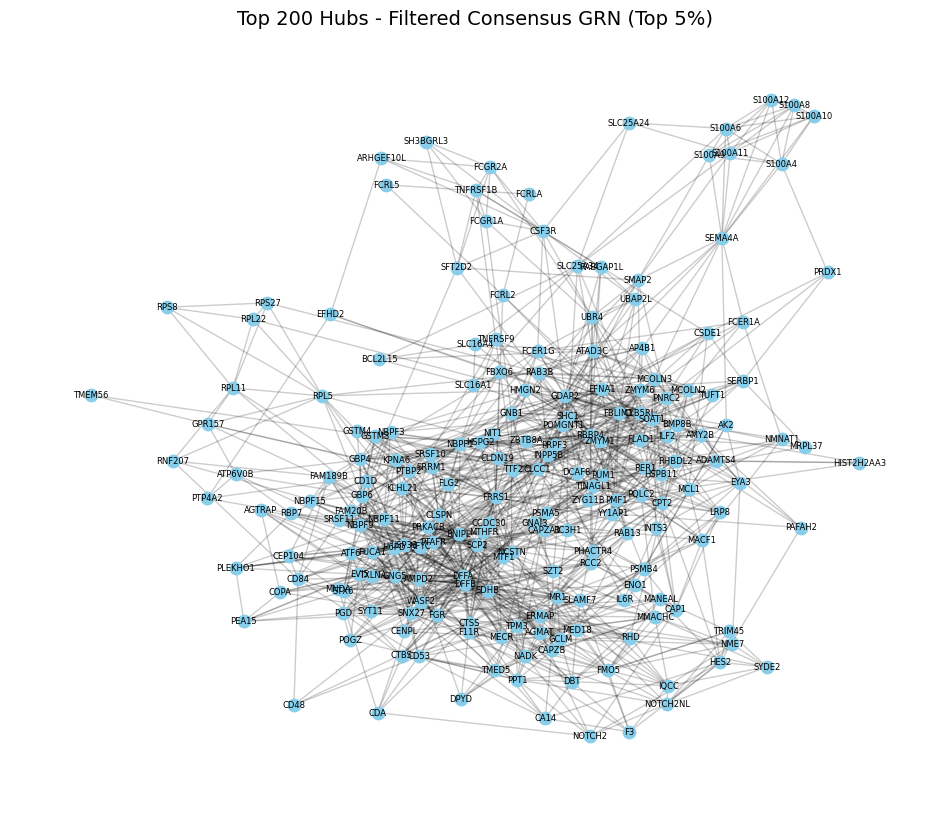


✅ FILTERED GRN and Cytoscape export complete!
Outputs:
 • Filtered consensus edges -> /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/consensus_grn_top5pct.csv
 • Cytoscape nodes -> /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/cytoscape_nodes.csv
 • Cytoscape edges -> /users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500/cytoscape_edges.csv


In [24]:
# 12. Optional visualization: top 200 hubs in filtered network
# ============================================================

G_top = nx.from_pandas_edgelist(filtered_df, "source", "target", edge_attr="weight")
deg_w = dict(G_top.degree(weight="weight"))
top200 = sorted(deg_w.items(), key=lambda x: x[1], reverse=True)[:200]
top_nodes = [n for n, _ in top200]
subG = G_top.subgraph(top_nodes)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, k=0.25)
nx.draw_networkx_nodes(subG, pos, node_size=80, node_color="skyblue")
nx.draw_networkx_edges(subG, pos, alpha=0.2)
nx.draw_networkx_labels(subG, pos, font_size=6)
plt.title("Top 200 Hubs - Filtered Consensus GRN (Top 5%)", fontsize=14)
plt.axis("off")
plt.show()

print("\n✅ FILTERED GRN and Cytoscape export complete!")
print("Outputs:")
print(f" • Filtered consensus edges -> {filtered_csv}")
print(f" • Cytoscape nodes -> {nodes_csv}")
print(f" • Cytoscape edges -> {edges_csv}")

In [7]:
import pandas as pd
import networkx as nx
import os

# Paths (adjust if different)
output_base = "/users/hmcmakhubela/Dataset/ChIP_cell Dataset/Immune_ALL_human/TFs+500"
consensus_csv = os.path.join(output_base, "consensus_grn.csv")  # CSV from step 9
graph_gml = os.path.join(output_base, "grn_graph.gml")           # optional GML

# Option 1: load from CSV
edges_df = pd.read_csv(consensus_csv)
G_cons = nx.from_pandas_edgelist(edges_df, "source", "target", edge_attr="weight")

print(f"Consensus GRN loaded. Nodes: {G_cons.number_of_nodes()}, Edges: {G_cons.number_of_edges()}")


Consensus GRN loaded. Nodes: 1000, Edges: 40704


In [8]:
deg_w = dict(G_cons.degree(weight="weight"))
top200 = sorted(deg_w.items(), key=lambda x: x[1], reverse=True)[:200]
top_nodes = [n for n, _ in top200]

print(f"Top 200 hub genes defined. Example genes: {top_nodes[:10]}")


Top 200 hub genes defined. Example genes: ['KCND3', 'GMEB1', 'RBBP4', 'FNDC5', 'PMF1', 'GTF2B', 'RUSC1', 'THBS3', 'ACP6', 'RPRD2']


In [12]:
!pip install enrichrpy


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 1.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 362.0 kB/s eta 0:00:00a 0:00:01
  Created wheel for enrichrpy: filename=enrichrpy-0.1.0-py3-none-any.whl size=4953 sha256=c041b680d489313905c1eecca4da22bde5871b0b6ceb31a972dc5b6fe98b1f35
  Stored in directory: /users/hmcmakhubela/.cache/pip/wheels/ed/ff/f8/ec6f73a118e30b3be0f1d3f5818f6e539e9026cf0b5c8254b0
Successfully built enrichrpy
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
import requests

# Ensure your gene list is strings and valid
genes_str = "\n".join([str(g) for g in top_nodes])

# POST to Enrichr
payload = {
    "list": genes_str,
    "description": "Top200"
}
r = requests.post("https://maayanlab.cloud/Enrichr/addList", data=payload)

if r.status_code == 200:
    res_json = r.json()
    user_list_id = res_json['userListId']
    print("List added to Enrichr, userListId:", user_list_id)
    
    # Query multiple libraries
    libraries = ["Reactome_2022", "GO_Biological_Process_2023", "KEGG_2021_Human"]
    for lib in libraries:
        r2 = requests.get(f"https://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={lib}")
        if r2.status_code == 200:
            res = r2.json()
            print(f"\nTop 5 terms in {lib}:")
            for term in res[lib][:5]:
                print(term[1], term[2], term[3])  # Name, p-value, adj p-value
        else:
            print(f"Failed for {lib}: HTTP {r2.status_code}")
else:
    print("Failed to add gene list:", r.status_code, r.text)


Failed to add gene list: 400 <!DOCTYPE html>
<html lang="en">
<head>
	<title>Enrichr</title>
	<meta http-equiv="Content-Type" content="text/html;charset=UTF-8">
	<meta name="author" content="Edward Y. Chen"/>
	<meta name="viewport" content="width=750">
	<link rel="shortcut icon" type="image/x-icon" href="favicon.ico"/>
	<link rel="icon" type="image/ico" href="favicon.ico"/>
	<link rel="stylesheet" type="text/css" href="css/reset-min.css"/>
	<link href='https://fonts.googleapis.com/css?family=Droid+Sans' rel='stylesheet' type='text/css'/>
	<link rel="stylesheet" type="text/css" href="css/common.css"/>
	<link rel="stylesheet" type="text/css" href="css/login.css"/>
</head>
<body>
	<div id="logo">
		<a href="index.html"><img src="images/enrichr-icon.png"/><span>En</span><span class="red">rich</span><span>r</span></a>
	</div>
	<div class="clear"></div>
	<div id="content" class="beveled">
		<div class="title">Error</div>
		<div>
			org.apache.tomcat.util.http.fileupload.impl.InvalidContentTy